In [1]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
import sklearn
from keras import utils
from sklearn.preprocessing import LabelEncoder

In [2]:
# dir_path points towards where to find the image dataset
dir_path = "data/archive/Dataset_BUSI_with_GT/"
IMAGE_SHAPE = (224, 224)

# This is a good sample as it gives a good mix of val data
random_sample = 1


In [3]:
# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(1578, 1578)

In [4]:
# Count the number of labels to get an idea of how balanced the dataset is
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{'benign': 891, 'malignant': 421, 'normal': 266}


In [5]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 3)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['benign' 'malignant' 'normal']


In [6]:
# Create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)

len(selected_files), len(selected_labels)

(780, 780)

In [7]:
# Split the data into testing, training and validation data
# As using a random sample = 100, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(selected_files, selected_labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)


In [8]:
images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Preparing testing data


In [9]:
class_counts = [sum(col) for col in zip(*labels)]
print(f"Benign: {class_counts[0]}  Malignant: {class_counts[1]}  Normal: {class_counts[2]}")

Benign: 68  Malignant: 27  Normal: 22


In [10]:
model = keras.models.load_model("best_mixup_beta_model_2.h5")

In [11]:
basic_results = model.predict(np.stack(images))

4/4 [==============================] - 9s 2s/step


In [12]:
argmax_preds = [np.argmax(r) for r in basic_results]
labels = [np.argmax(label) for label in y_test] 
acc = sklearn.metrics.accuracy_score(labels,argmax_preds)

In [13]:
print(acc)

0.8034188034188035


In [14]:
initial_df = pd.DataFrame()
initial_df["class"] = labels 
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in basic_results]
initial_df["confidence_class_1"] = [alpha[1] for alpha in basic_results]
initial_df["confidence_class_2"] = [alpha[2] for alpha in basic_results]

In [15]:
class_zero_df = initial_df[initial_df["class"] == 0] 
class_one_df = initial_df[initial_df["class"] == 1]
class_two_df = initial_df[initial_df["class"] == 2]
class_one_length = len(class_one_df)
class_two_length = len(class_two_df)
class_zero_length = len(class_zero_df)

In [16]:
print(class_zero_length,class_one_length,class_two_length)

68 27 22


In [17]:
def get_balance_iters(label):
    # Returns a value for over-sampling if balancing the data
    if label[0] == 1: # Benign
        return 1
    elif label[1] == 1: # Malignant
        return 2
    else: # Normal
        return 3

# The data augmentation to do. This applies a random horizontal flip and a random tilt.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation((-0.3, 0.3)),
])

In [18]:
# IMPORTANT

MUBA_BALANCE = True # If true data will be oversampled to create balanced classes
AUGMENT = True # Recommended True if balancing

MUBA_ITERS = 20 # How many times to create mix up images per image

In [19]:
muba_df_01 = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image",
    ])
muba_df_02 = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image",
    ])
muba_df_12 = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image",
    ])

In [20]:
def return_muba_df(df1,df2,MUBA_ITERS = MUBA_ITERS):

    muba_df = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image"])

    for index0, row0 in df1.iterrows():

        for index1, row1 in df2.iterrows():

            for i in range(MUBA_ITERS):
                    
                # Mixup images
                lam = (1/MUBA_ITERS) * np.random.rand() + ( (i) / MUBA_ITERS)
                new_img = lam * images[int(row0["image_index"])] + (1 - lam) * images[int(row1["image_index"])]

                row = pd.DataFrame([({ "alpha_class_0": lam, # row 0 is multiplied by lam
                        "alpha_class_1": 1-lam,
                        "image": new_img,
                        })])
                    
                    
                muba_df = pd.concat([muba_df, row],axis=0, ignore_index=True)

    return muba_df



muba_df_01 = return_muba_df(class_zero_df,class_one_df)
muba_df_02 = return_muba_df(class_zero_df,class_two_df)
muba_df_12 = return_muba_df(class_one_df, class_two_df)
    

            

In [21]:
# Get Predictions
result_01 = model.predict(np.stack(muba_df_01["image"]))
result_02 = model.predict(np.stack(muba_df_02["image"]))
result_12 = model.predict(np.stack(muba_df_12["image"]))

372/372 [==============================] - 919s 2s/step


In [22]:
analysis_df_01 = muba_df_01.drop('image',axis=1)
analysis_df_02 = muba_df_02.drop('image',axis=1)
analysis_df_12 = muba_df_12.drop('image',axis=1)

In [23]:
def get_boundary_points(df,result):
    
    predictions = pd.DataFrame()
    predictions["pred"] = [np.argmax(res) for res in result]

    # Merge on predictions
    analysis_df = df.join(predictions)
    boundary_df = pd.DataFrame(columns = ["alpha"])

    for i in range(int(len(analysis_df)/MUBA_ITERS)):
        # Create a mask to split df in to blocks of 20
        mask = (analysis_df.index >= MUBA_ITERS*i) & (analysis_df.index < MUBA_ITERS*i + MUBA_ITERS)
        window_df = analysis_df.loc[mask]

        # Find the index in which the prediction changes
        changing_pred_index = (window_df["pred"].diff()[window_df["pred"].diff() != 0].index.values)
        for boundary in changing_pred_index[1:]: # If pred doesn't change will equal 1
            row0 = window_df[window_df.index == boundary-1]
            row1 = window_df[window_df.index == boundary]
            middle_alpha = (row1["alpha_class_1"][boundary] + row0["alpha_class_1"][boundary-1]) / 2 
            new_row = pd.DataFrame([{
                "alpha":middle_alpha,
            }])
            
            boundary_df = pd.concat([boundary_df, new_row], axis=0, ignore_index = True)
    
    return boundary_df,analysis_df

boundary_01,analysis_df_01 = get_boundary_points(analysis_df_01,result_01)
boundary_02,analysis_df_02 = get_boundary_points(analysis_df_02,result_02)
boundary_12,analysis_df_12 = get_boundary_points(analysis_df_12,result_12)

In [24]:
analysis_df_02

,alpha_class_0,alpha_class_1,pred
0,0.006102,0.993898,0
1,0.092747,0.907253,1
2,0.105685,0.894315,1
3,0.176751,0.823249,1
4,0.245005,0.754995,1
...,...,...,...
29915,0.756541,0.243459,0
29916,0.806327,0.193673,0
29917,0.884056,0.115944,0
29918,0.929472,0.070528,0


In [25]:
incorrect_alphas_01 = (analysis_df_01[analysis_df_01["pred"] != analysis_df_01["alpha_class_1"].round()])["alpha_class_1"]

# Corrrect if alpha_class_1 > 0.5 and prediction == 2 , or if alpha_class_1 < 0.5 and prediction == 0
incorrect_alphas_02 = (analysis_df_02[ ((analysis_df_02["alpha_class_1"].round() == 1) & (analysis_df_02["pred"] != 2)) | ((analysis_df_02["alpha_class_1"].round() == 0) & (analysis_df_02["pred"] != 0)) ])["alpha_class_1"]

# # If correct, pred should = 1+1 when round(alpha_class_1) == 1 OR pred should = 0+1 when round(alpha_class_0) == 0 
incorrect_alphas_12 = (analysis_df_12[analysis_df_12["pred"] != analysis_df_12["alpha_class_1"].round()+1])["alpha_class_1"]

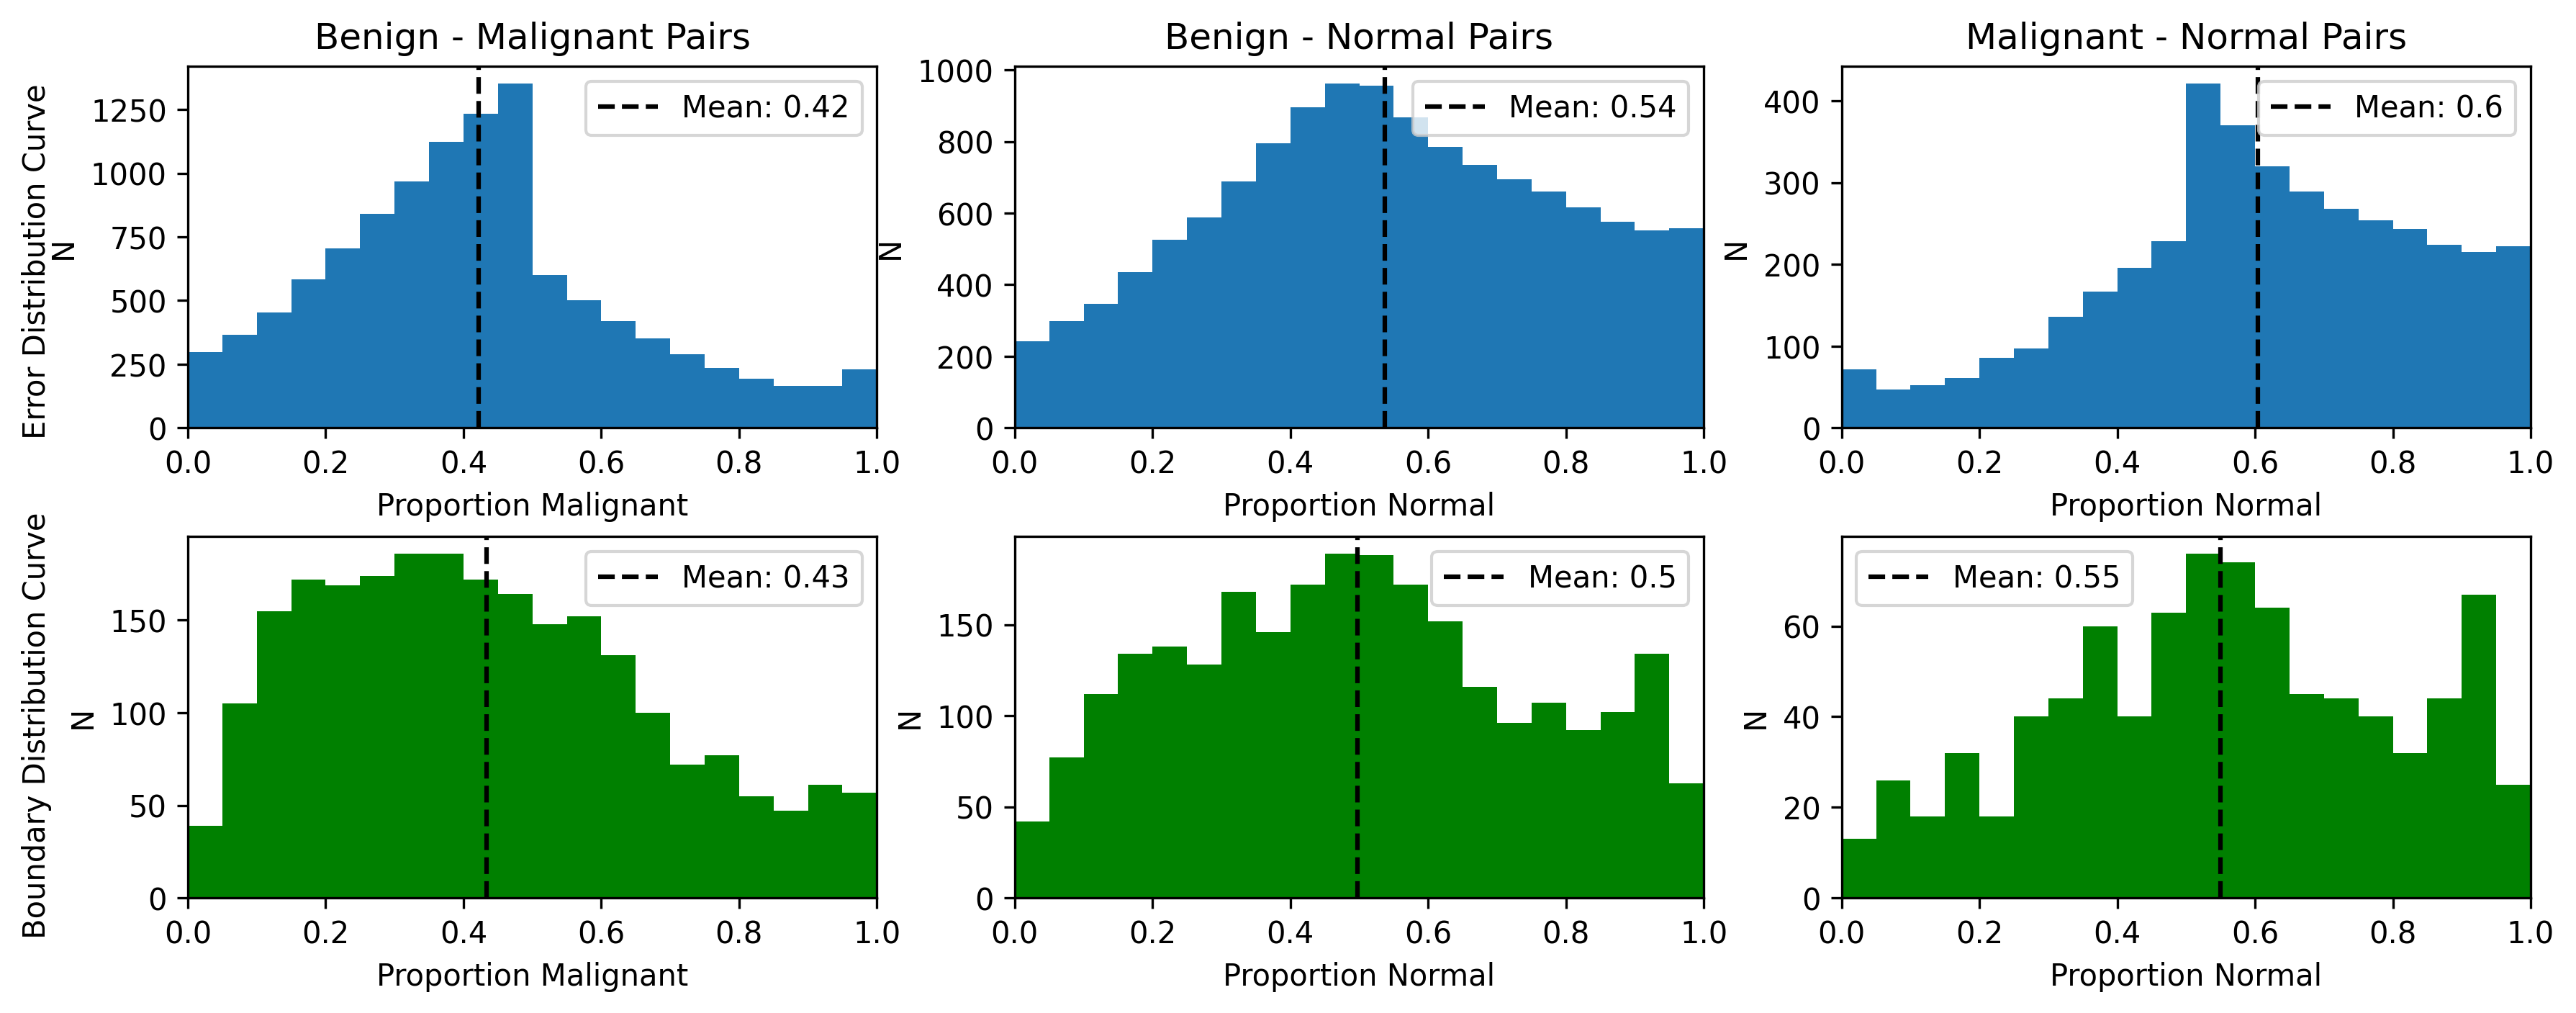

In [31]:
fig, axs = plt.subplots(2,3, figsize = (14,5))

plt.subplots_adjust(hspace=0.3,wspace=0.2)
for ax in axs.flatten():
    ax.set_xlim(0,1)

axs[0][0].hist(incorrect_alphas_01, bins = [0.05*i for i in range(21)])
axs[0][0].set_title("Benign - Malignant Pairs",)
axs[0][0].set_xlabel("Proportion Malignant")
axs[0][0].set_ylabel("N")
axs[0][0].axvline(np.mean(incorrect_alphas_01),color = "black", linestyle="--", label = f"Mean: {round(np.mean(incorrect_alphas_01),2)}")
axs[0][0].legend()

axs[0][1].hist(incorrect_alphas_02, bins = [0.05*i for i in range(21)])
axs[0][1].set_title("Benign - Normal Pairs")
axs[0][1].set_xlabel("Proportion Normal")
axs[0][1].set_ylabel("N")
axs[0][1].axvline(np.mean(incorrect_alphas_02),color = "black", linestyle="--", label = f"Mean: {round(np.mean(incorrect_alphas_02),2)}")
axs[0][1].legend()

axs[0][2].hist(incorrect_alphas_12, bins = [0.05*i for i in range(21)])
axs[0][2].set_title("Malignant - Normal Pairs",)
axs[0][2].set_xlabel("Proportion Normal")
axs[0][2].set_ylabel("N")
axs[0][2].axvline(np.mean(incorrect_alphas_12),color = "black", linestyle="--", label = f"Mean: {round(np.mean(incorrect_alphas_12),2)}")
axs[0][2].legend()
axs[1][0].hist(boundary_01["alpha"], bins = [0.05*i for i in range(21)], color = "green")
axs[1][0].set_xlabel("Proportion Malignant")
axs[1][0].set_ylabel("N")
axs[1][0].axvline(np.mean(boundary_01["alpha"]),color = "black", linestyle="--", label = f"Mean: {round(np.mean(boundary_01['alpha']),2)}")
axs[1][0].legend()

axs[1][1].hist(boundary_02["alpha"], bins = [0.05*i for i in range(21)], color = "green")
axs[1][1].set_xlabel("Proportion Normal")
axs[1][1].set_ylabel("N")
axs[1][1].axvline(np.mean(boundary_02["alpha"]),color = "black", linestyle="--", label = f"Mean: {round(np.mean(boundary_02['alpha']),2)}")
axs[1][1].legend()

axs[1][2].hist(boundary_12["alpha"], bins = [0.05*i for i in range(21)], color = "green")
axs[1][2].set_xlabel("Proportion Normal")
axs[1][2].set_ylabel("N")
axs[1][2].axvline(np.mean(boundary_12["alpha"]),color = "black", linestyle="--", label = f"Mean: {round(np.mean(boundary_12['alpha']),2)}")
axs[1][2].legend()

fig.text(0.07,0.7,"Error Distribution Curve", rotation = 90, va = "center")
fig.text(0.07,0.27,"Boundary Distribution Curve", rotation = 90, va = "center")

fig.set_dpi(300)